In [1]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.metrics import recall_score, classification_report

from torchvision.datasets import ImageFolder
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Загрузка датасета с буквами

In [3]:
import zipfile
from tqdm import tqdm

zf = zipfile.ZipFile('/content/drive/MyDrive/ML/экзамен/images/eng_handwritten.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 2887/2887 [00:01<00:00, 2252.60it/s]


In [4]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

dataset = ImageFolder(root='eng_handwritten', transform=transform)

### Подготовка датасета

In [5]:
size = int(len(dataset) * .85)
train_dataset, test_dataset = random_split(dataset, lengths=(size, len(dataset) - size), generator=torch.Generator().manual_seed(123))

In [6]:
len(train_dataset), len(test_dataset)

(2431, 429)

In [7]:
batch_size = 15

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

print("The train set contains {} images, in {} batches".format(len(train_dataset), len(train_loader)))
print("The test set contains {} images, in {} batches".format(len(test_dataset), len(test_loader)))

The train set contains 2431 images, in 304 batches
The test set contains 429 images, in 54 batches


### Обучение нейронной сети

In [10]:
import time

def time_since(since):
    now = time.time()
    s = now - since
    m = np.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.linear = nn.Sequential(
            nn.Linear(256 * 2 * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 26)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, 256 * 2 * 2)
        x = self.linear(x)
        return x


Epoch:    1/10 | 1m 35s    | Training loss: 3.078.. | (test) accuracy => 0.08 | (test) f1-score => 0.03
Epoch:    2/10 | 3m 6s     | Training loss: 2.684.. | (test) accuracy => 0.19 | (test) f1-score => 0.13
Epoch:    3/10 | 4m 35s    | Training loss: 2.041.. | (test) accuracy => 0.48 | (test) f1-score => 0.43
Epoch:    4/10 | 6m 5s     | Training loss: 1.323.. | (test) accuracy => 0.67 | (test) f1-score => 0.66
Epoch:    5/10 | 7m 34s    | Training loss: 0.817.. | (test) accuracy => 0.75 | (test) f1-score => 0.74
Epoch:    6/10 | 9m 12s    | Training loss: 0.544.. | (test) accuracy => 0.82 | (test) f1-score => 0.82
Epoch:    7/10 | 10m 44s   | Training loss: 0.406.. | (test) accuracy => 0.82 | (test) f1-score => 0.82
Epoch:    8/10 | 12m 21s   | Training loss: 0.289.. | (test) accuracy => 0.82 | (test) f1-score => 0.82
Epoch:    9/10 | 13m 56s   | Training loss: 0.231.. | (test) accuracy => 0.84 | (test) f1-score => 0.84
Epoch:   10/10 | 15m 29s   | Training loss: 0.194.. | (test) acc

Text(0.5, 1.0, 'train')

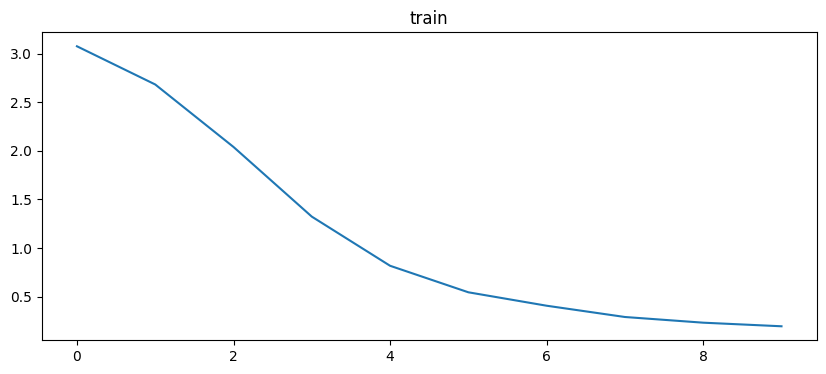

In [25]:
n_epoch = 10 + 1
lr=0.001
criterion = nn.CrossEntropyLoss()

model = Net()
optimizer = optim.Adam(model.parameters(), lr = lr)
losses_list = []
test_losses_list = []
log_interval = 1

start = time.time()
for epoch in range(1, n_epoch):
    running_loss = 0
    test_loss = 0
    for features, target in train_loader:
        optimizer.zero_grad()
        output = model.forward(features)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses = running_loss/len(train_loader)
    losses_list.append(losses)

    true_list, pred_list = [], []
    model.eval()
    for features, target in test_loader:
        output = model.forward(features)
        loss = criterion(output, target)
        test_loss += loss.item()
        _, pred = torch.max(output, 1)
        true_list += target.numpy().tolist()
        pred_list += np.squeeze(pred.numpy()).tolist()
    losses_ = test_loss/len(test_loader)
    test_losses_list.append(losses_)
    if epoch % log_interval == 0:
        print("Epoch: {:4}/{} |".format(epoch, n_epoch-1),
              "{:9} |".format(time_since(start)),
              "Training loss: {:.3f}.. |".format(losses),
              "(test) accuracy => {:.2f} |".format(accuracy_score(true_list, pred_list)),
              "(test) f1-score => {:.2f}".format(f1_score(true_list, pred_list, average="weighted")))

print('Finished Training')

fig, axs = plt.subplots(figsize=(10, 4))
axs.plot(range(len(losses_list)), losses_list)
axs.set_title("train")

In [36]:
from sklearn.metrics import classification_report
import string

model.eval()
test_loss = 0
correct = 0
true_list = []
pred_list = []
result_ = {}
result_v = {}
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += criterion(output, target)
        _, pred = torch.max(output, 1)
        true_list += target.numpy().tolist()
        pred_list += np.squeeze(pred.numpy()).tolist()

test_loss /= len(test_loader.dataset)


english = list(string.ascii_uppercase)
true_list_ = [english[i] for i in true_list]
pred_list_ = [english[i] for i in pred_list]

print(f'Avg. loss: {test_loss:.4f}')
print(classification_report(true_list_, pred_list_))

Avg. loss: 0.0670
              precision    recall  f1-score   support

           A       0.86      0.71      0.77        17
           B       0.89      1.00      0.94         8
           C       0.88      1.00      0.94        15
           D       0.85      0.92      0.88        12
           E       0.93      0.74      0.82        19
           F       0.88      1.00      0.93        21
           G       0.93      1.00      0.97        14
           H       1.00      0.53      0.69        17
           I       0.69      0.64      0.67        14
           J       1.00      0.79      0.88        14
           K       0.79      0.96      0.87        24
           L       0.85      0.94      0.89        18
           M       1.00      0.58      0.74        12
           N       0.76      0.62      0.68        21
           O       0.94      1.00      0.97        16
           P       0.93      0.78      0.85        18
           Q       0.71      0.86      0.77        14
         

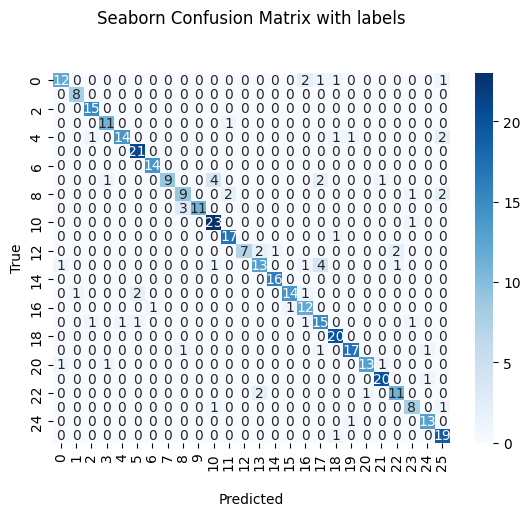

In [41]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(true_list_, pred_list_)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('True');
plt.show()